# Inspect the single-lineage model run on the prostate data (002)

Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qnorm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-prostate-002_PYMC_NUMPYRO"

### Load posterior summary

In [6]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name
0,mu_mu_a,0.099,0.020,0.077,0.121,0.010,0.008,5.0,12.0,2.14,mu_mu_a
1,mu_b,0.001,0.003,-0.003,0.004,0.001,0.001,5.0,28.0,2.10,mu_b
2,mu_d,-0.020,0.001,-0.022,-0.018,0.001,0.000,6.0,48.0,2.01,mu_d
3,mu_f,0.067,0.077,0.011,0.201,0.038,0.029,5.0,11.0,2.87,mu_f
4,mu_h[ZFHX3],-0.024,0.017,-0.043,-0.006,0.008,0.006,5.0,11.0,2.24,mu_h


### Load trace object

In [7]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [8]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[_broad_only],
)

In [9]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,lineage_subtype,primary_or_metastasis,is_male,age
0,AAAGCCCAGGAGTATGGGAG,Vcap-304Cas9_RepA_p4_batch3,0.246450,3,chr2_130522105_-,CFC1B,broad,True,2,130522105,...,NaN,NaN,NaN,False,0.999455,prostate,prostate_adenocarcinoma,metastasis,True,59.0
1,AAATCAGAGAAACCTGAACG,Vcap-304Cas9_RepA_p4_batch3,0.626518,3,chr11_89916950_-,TRIM49D1,broad,True,11,89916950,...,NaN,NaN,NaN,False,1.281907,prostate,prostate_adenocarcinoma,metastasis,True,59.0
2,AACGTCTTTGAAGAAAGCTG,Vcap-304Cas9_RepA_p4_batch3,0.165114,3,chr5_71055421_-,GTF2H2,broad,True,5,71055421,...,NaN,NaN,NaN,False,0.616885,prostate,prostate_adenocarcinoma,metastasis,True,59.0
3,AACGTCTTTGAAGGAAGCTG,Vcap-304Cas9_RepA_p4_batch3,-0.094688,3,chr5_69572480_+,GTF2H2C,broad,True,5,69572480,...,NaN,NaN,NaN,False,0.616885,prostate,prostate_adenocarcinoma,metastasis,True,59.0
4,AAGAGGTTCCAGACTACTTA,Vcap-304Cas9_RepA_p4_batch3,0.294496,3,chrX_155898173_+,VAMP7,broad,True,X,155898173,...,NaN,NaN,NaN,False,0.615935,prostate,prostate_adenocarcinoma,metastasis,True,59.0


### Single lineage model

In [10]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [11]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[07/26/22 06:50:42] INFO     Processing data for modeling.     ]8;id=768282;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=902855;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#267\267]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=707425;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=44367;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#268\268]8;;\

[07/26/22 06:51:44] WARNING  number of data points dropped: 2  ]8;id=41969;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=130663;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#319\319]8;;\

                    INFO     number of genes mutated in all    ]8;id=377802;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=715039;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#449\449]8;;\
                             cells lines: 0                                                  

                    INFO     Dropping 8 cancer genes.          ]8;id=269142;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=424251;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#505\505]8;;\

## Analysis

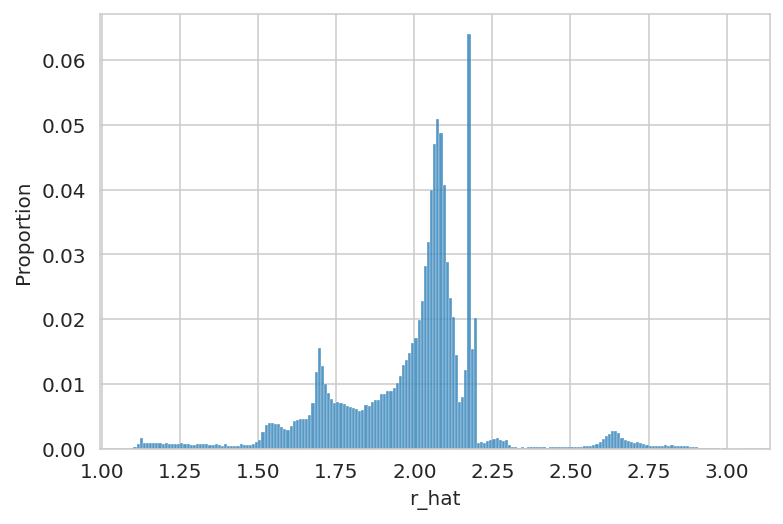

In [12]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

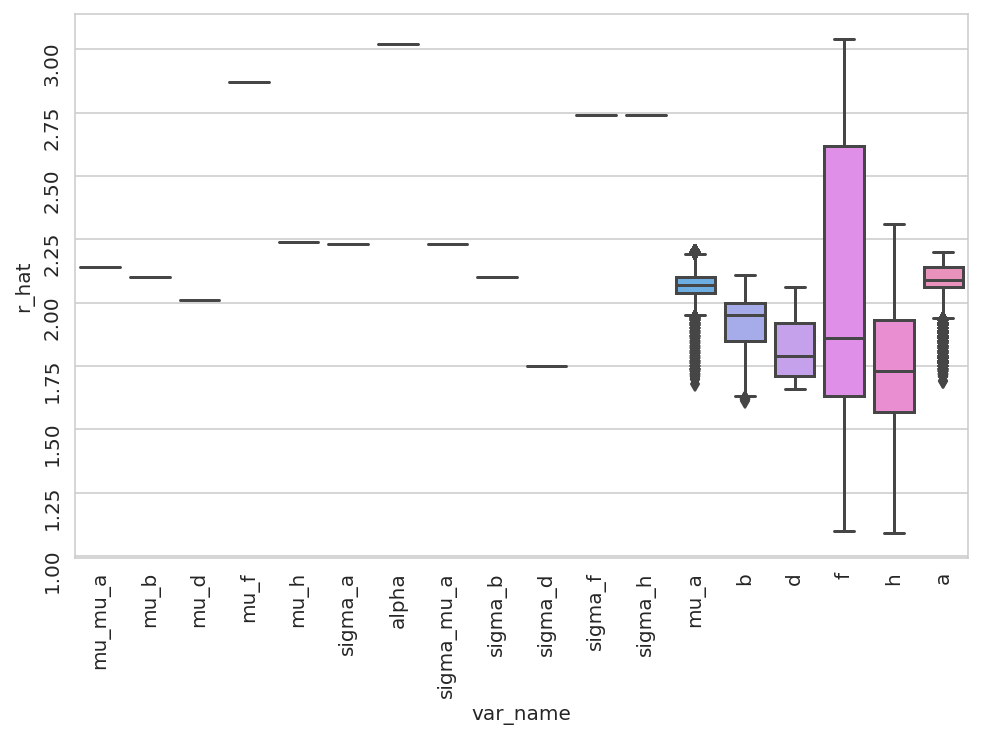

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

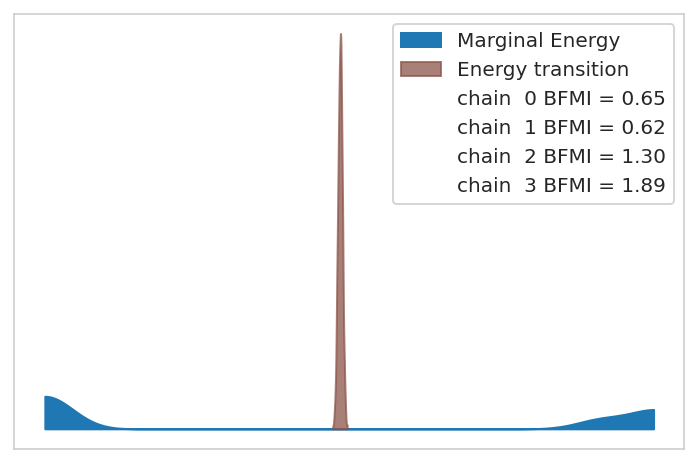

In [14]:
az.plot_energy(trace);

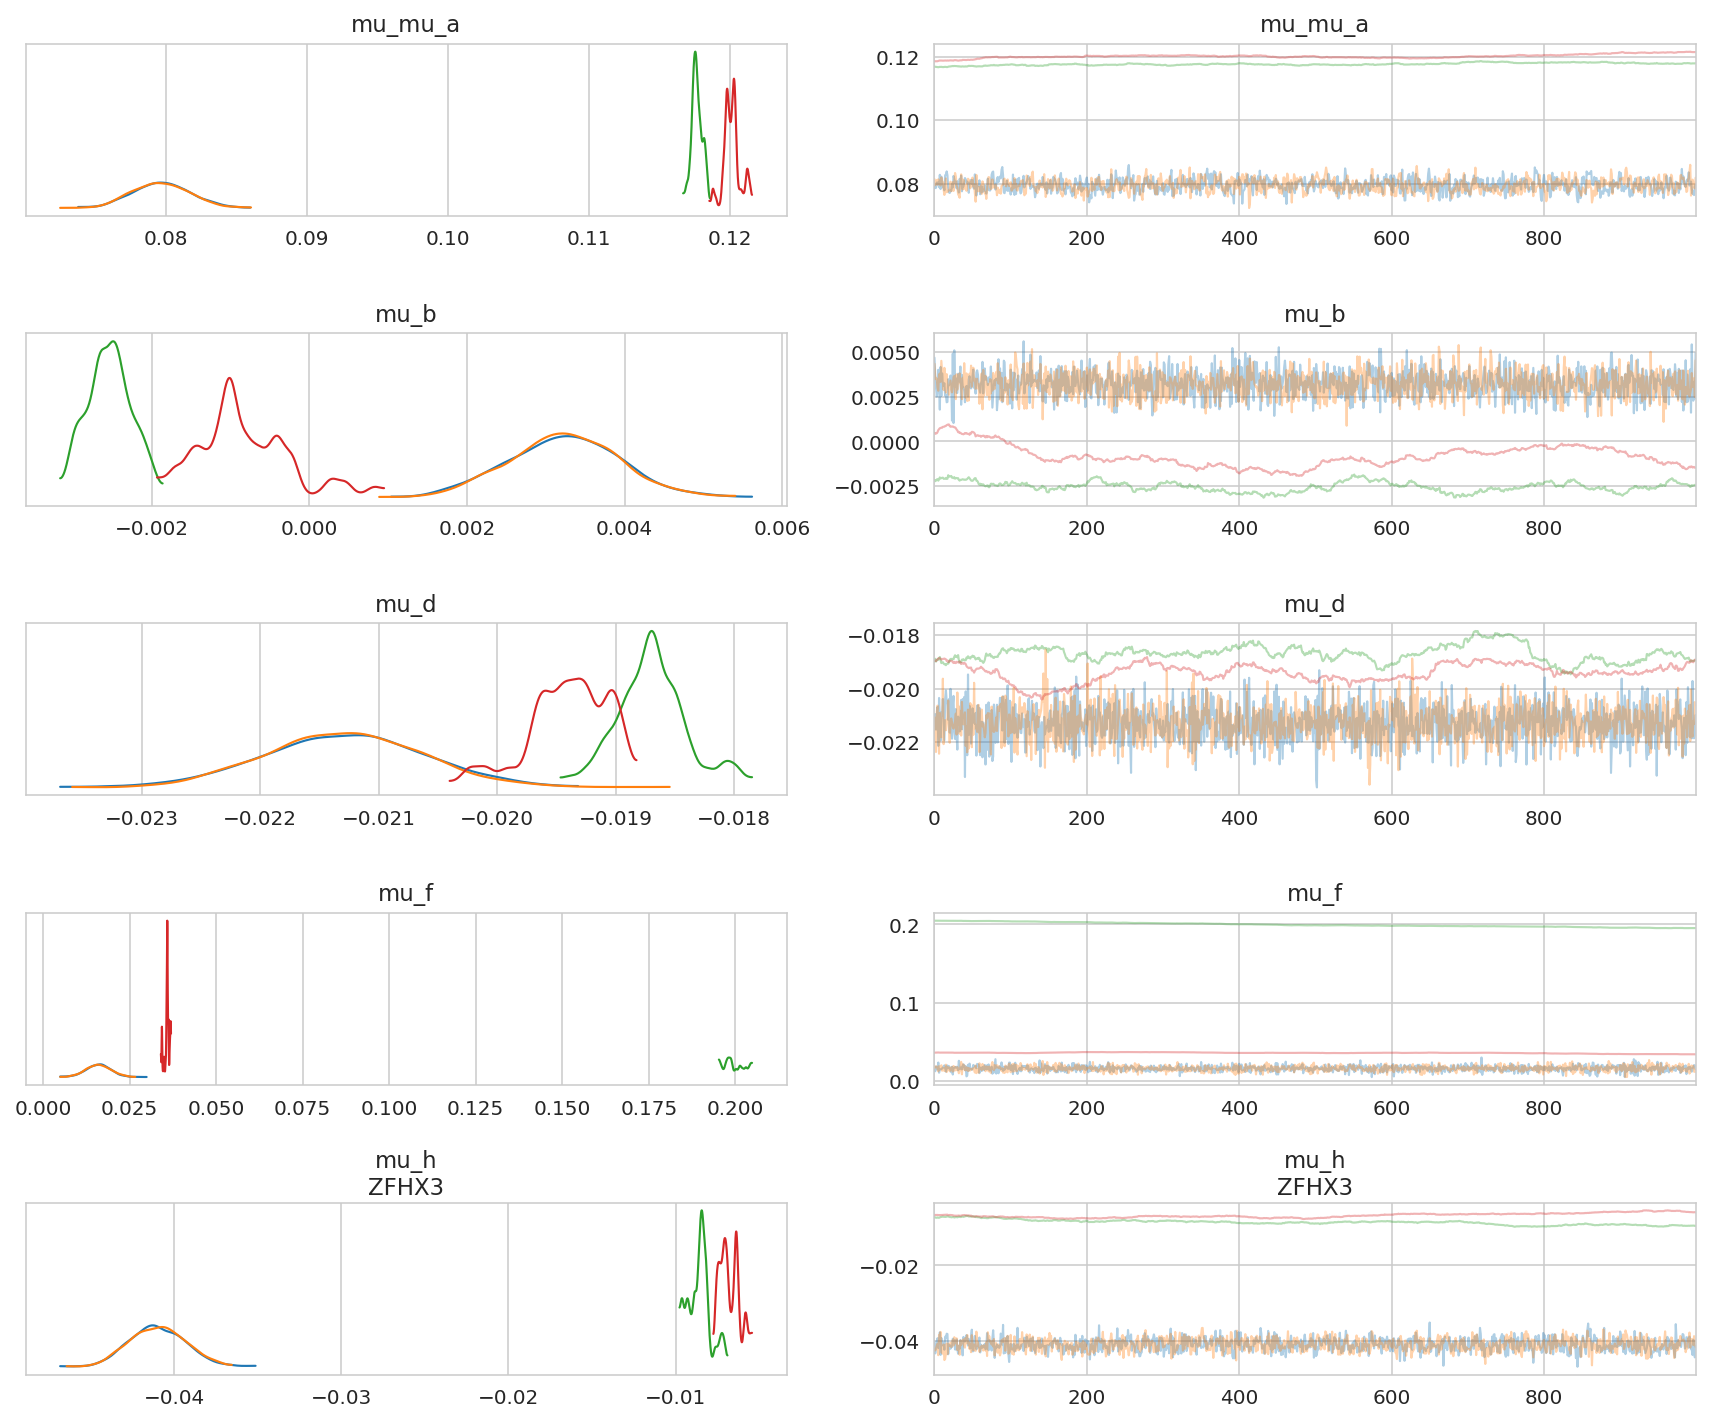

In [15]:
az.plot_trace(
    trace, var_names=["mu_mu_a", "mu_b", "mu_d", "mu_f", "mu_h"], compact=False
)
plt.tight_layout()

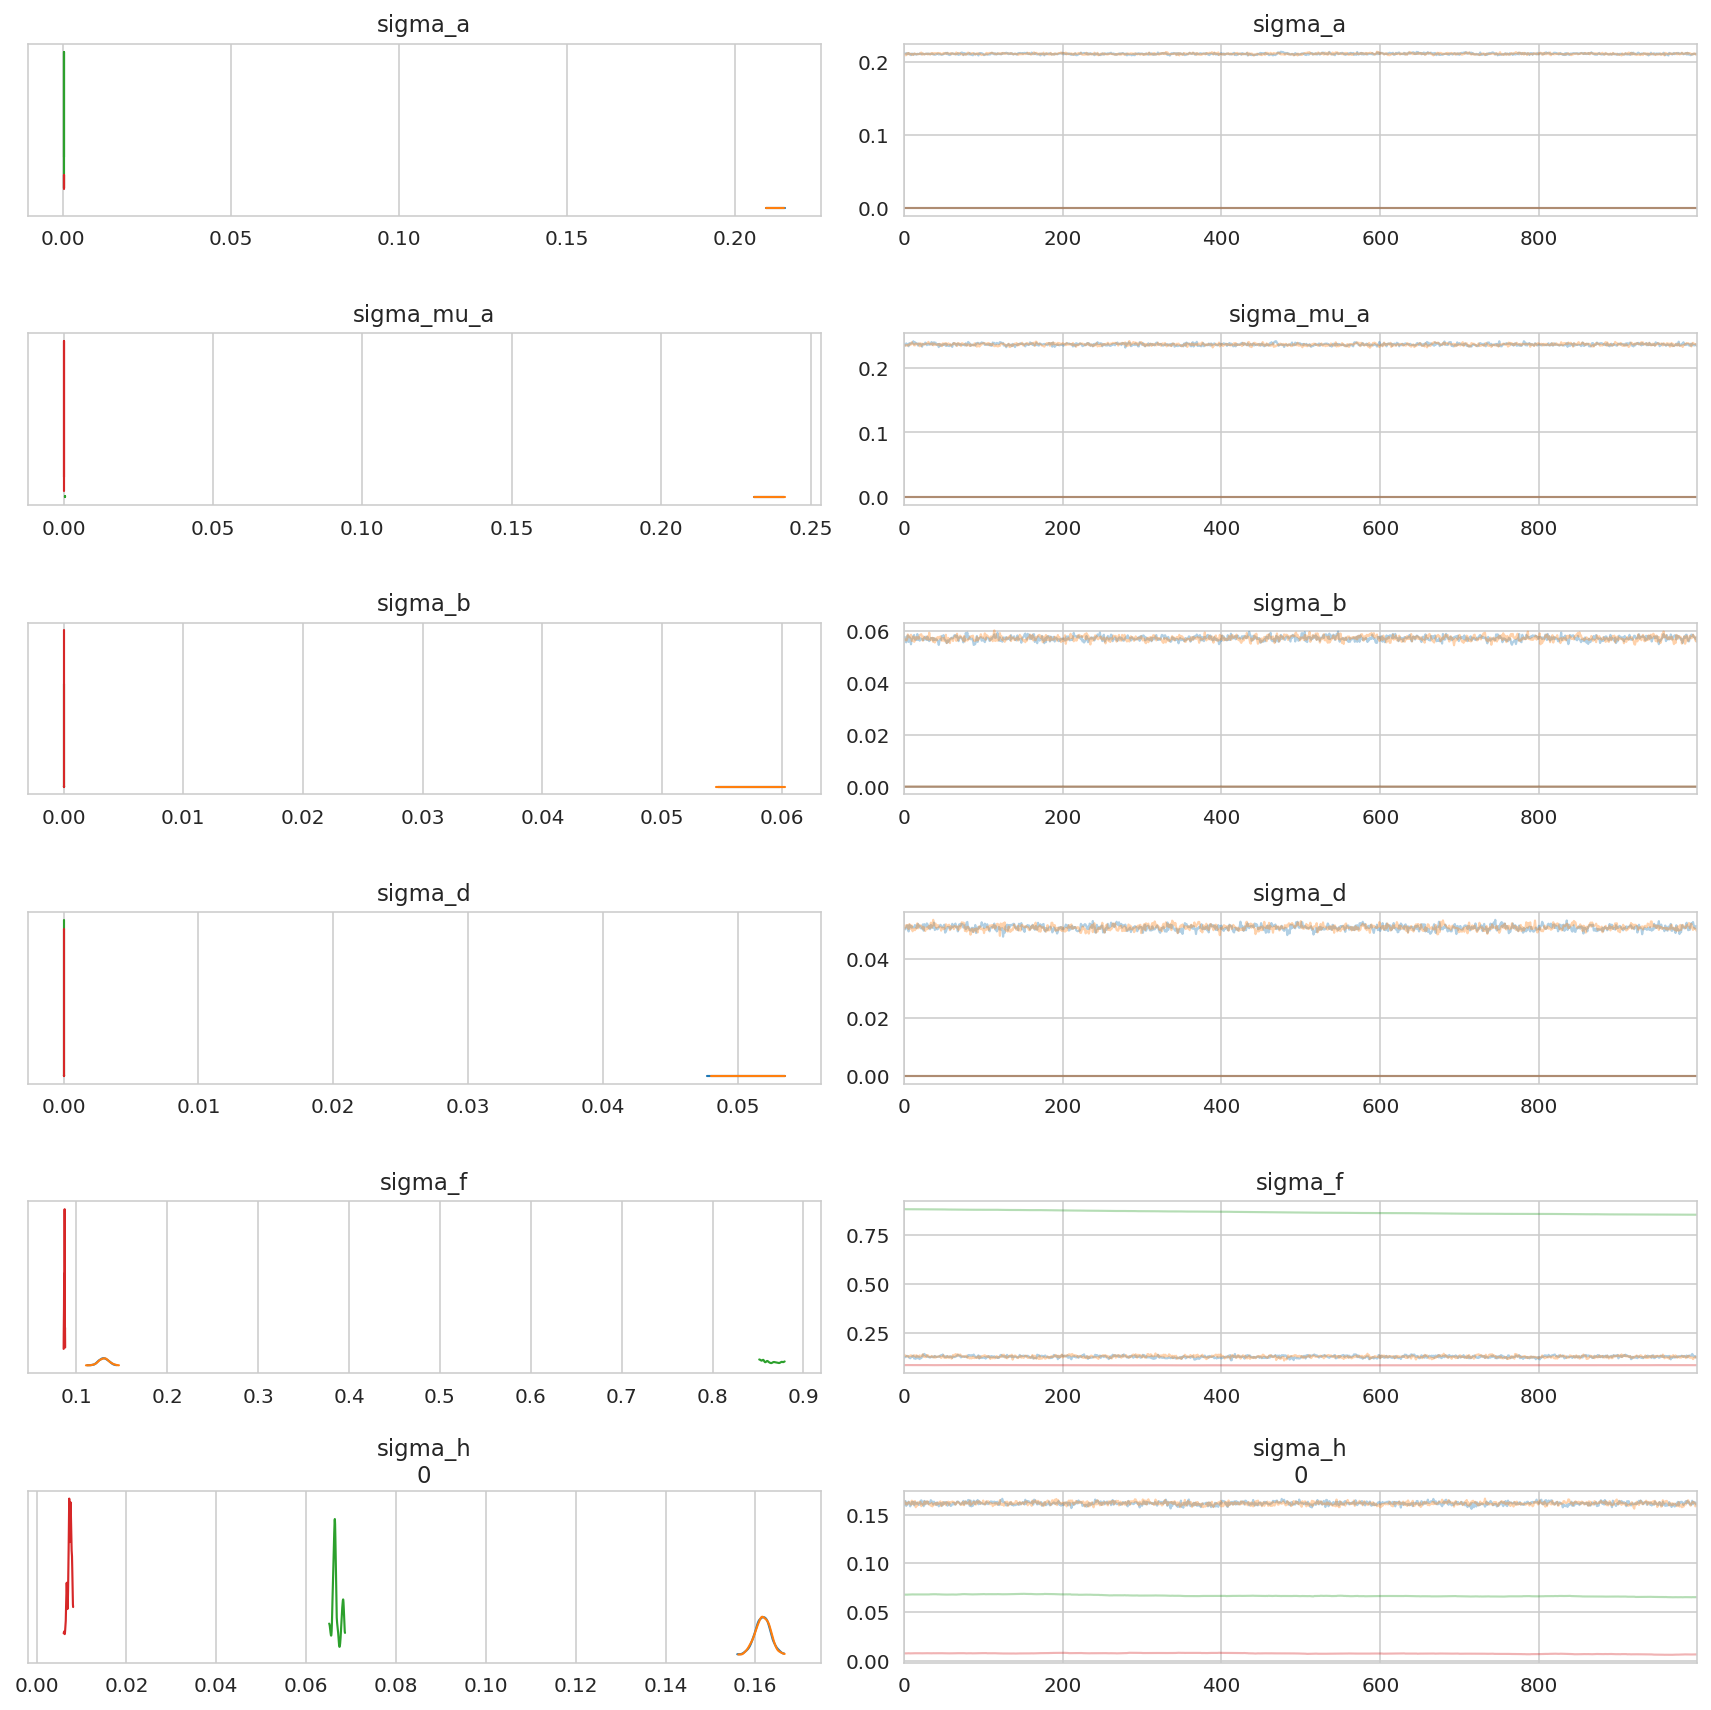

In [16]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

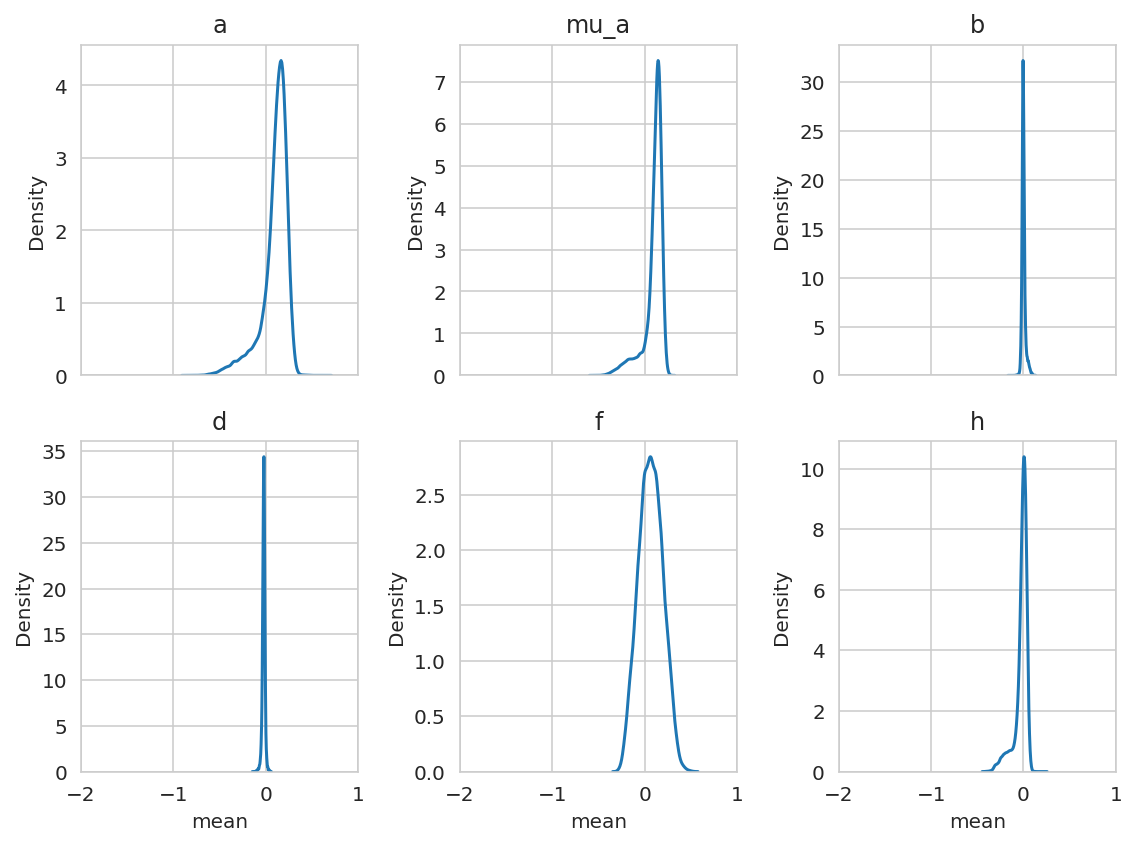

In [17]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [18]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [19]:
(
    prostate_post_summary.query("var_name == 'mu_a'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=5)
)

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name
0,mu_a[KIF11],-0.552,0.674,-1.298,0.122,0.334,0.256,5.0,12.0,2.18,mu_a
1,mu_a[HSPE1],-0.463,0.586,-1.123,0.122,0.290,0.222,5.0,12.0,2.18,mu_a
2,mu_a[SPC24],-0.461,0.584,-1.122,0.122,0.289,0.221,5.0,12.0,2.18,mu_a
3,mu_a[RAN],-0.451,0.573,-1.094,0.122,0.284,0.217,5.0,12.0,2.18,mu_a
4,mu_a[EEF2],-0.449,0.572,-1.094,0.122,0.283,0.216,5.0,12.0,2.18,mu_a
18114,mu_a[PRAMEF4],0.257,0.153,0.117,0.468,0.069,0.052,5.0,14.0,2.16,mu_a
18115,mu_a[EPHA2],0.257,0.154,0.116,0.471,0.069,0.052,5.0,14.0,2.15,mu_a
18116,mu_a[ARHGAP44],0.259,0.154,0.117,0.468,0.070,0.053,5.0,14.0,2.15,mu_a
18117,mu_a[HLA-DQB1],0.265,0.163,0.117,0.490,0.073,0.055,5.0,14.0,2.14,mu_a
18118,mu_a[TP53],0.283,0.176,0.116,0.515,0.082,0.062,5.0,14.0,2.20,mu_a


In [20]:
(
    prostate_post_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=5)
)

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name
0,b[EP300],-0.161,0.162,-0.352,0.001,0.080,0.061,5.0,27.0,2.1,b
1,b[TP63],-0.091,0.094,-0.213,0.001,0.045,0.034,5.0,27.0,2.1,b
2,b[STAG2],-0.088,0.091,-0.205,0.001,0.043,0.033,5.0,27.0,2.1,b
3,b[EBP],-0.084,0.089,-0.205,0.001,0.041,0.031,5.0,27.0,2.1,b
4,b[FOXA1],-0.083,0.086,-0.197,0.001,0.041,0.031,5.0,27.0,2.1,b
18114,b[ATP6V1F],0.109,0.114,-0.003,0.254,0.055,0.042,5.0,28.0,2.1,b
18115,b[MRPL57],0.111,0.117,-0.003,0.256,0.056,0.043,5.0,28.0,2.1,b
18116,b[GPI],0.119,0.124,-0.003,0.274,0.060,0.046,5.0,28.0,2.1,b
18117,b[AIFM1],0.124,0.130,-0.003,0.284,0.063,0.048,5.0,28.0,2.1,b
18118,b[NARS2],0.125,0.130,-0.003,0.283,0.063,0.048,5.0,28.0,2.1,b


In [21]:
(
    prostate_post_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=5)
)

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name
0,d[CHMP3],-0.138,0.122,-0.284,-0.018,0.059,0.045,5.0,48.0,2.04,d
1,d[ATP1A1],-0.132,0.117,-0.276,-0.018,0.056,0.043,5.0,48.0,2.04,d
2,d[LONP1],-0.114,0.099,-0.240,-0.018,0.048,0.036,5.0,48.0,2.04,d
3,d[TRIT1],-0.114,0.099,-0.240,-0.018,0.048,0.036,5.0,48.0,2.04,d
4,d[UBE2N],-0.113,0.097,-0.236,-0.018,0.047,0.036,5.0,48.0,2.04,d
18114,d[HCCS],0.051,0.076,-0.020,0.154,0.035,0.026,5.0,41.0,2.03,d
18115,d[ENO1],0.051,0.075,-0.020,0.150,0.035,0.027,5.0,40.0,2.04,d
18116,d[TARS2],0.053,0.077,-0.020,0.154,0.036,0.027,5.0,40.0,2.04,d
18117,d[MRPL39],0.055,0.079,-0.020,0.161,0.037,0.028,5.0,40.0,2.04,d
18118,d[DMAC1],0.057,0.081,-0.020,0.164,0.038,0.029,5.0,40.0,2.04,d


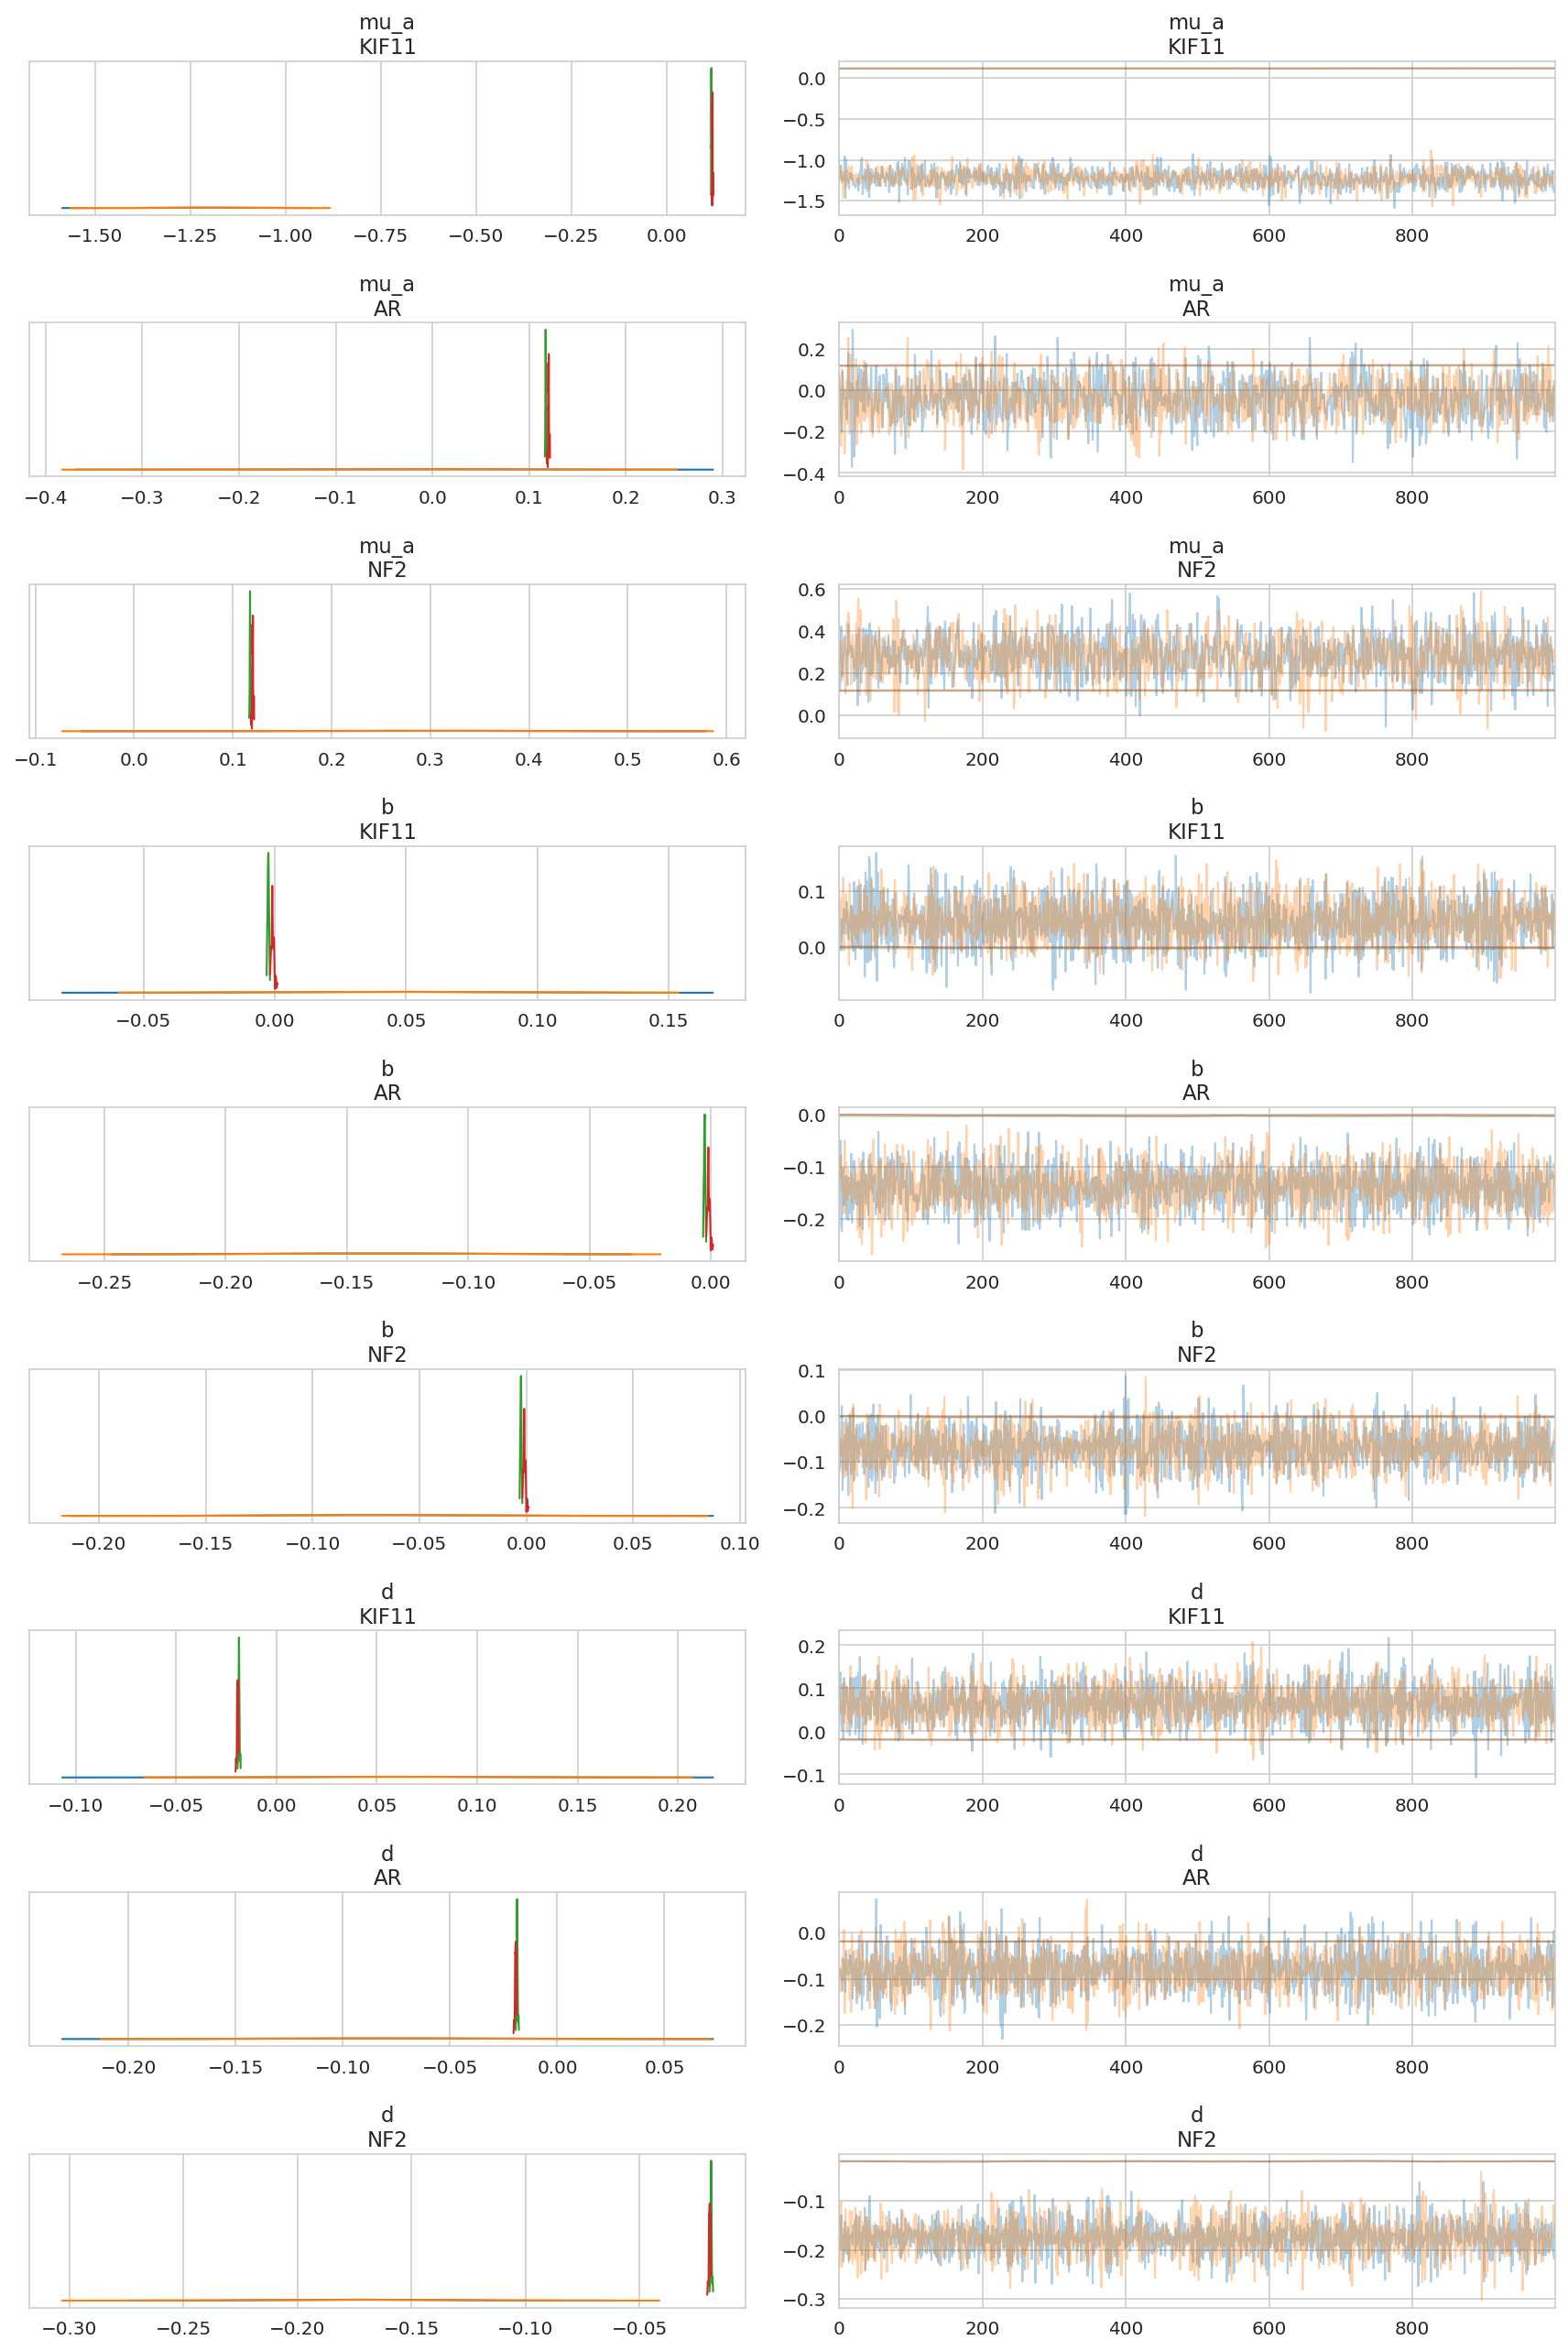

In [22]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace, var_names=["mu_a", "b", "d"], coords={"gene": example_genes}, compact=False
)
plt.tight_layout()
plt.show()

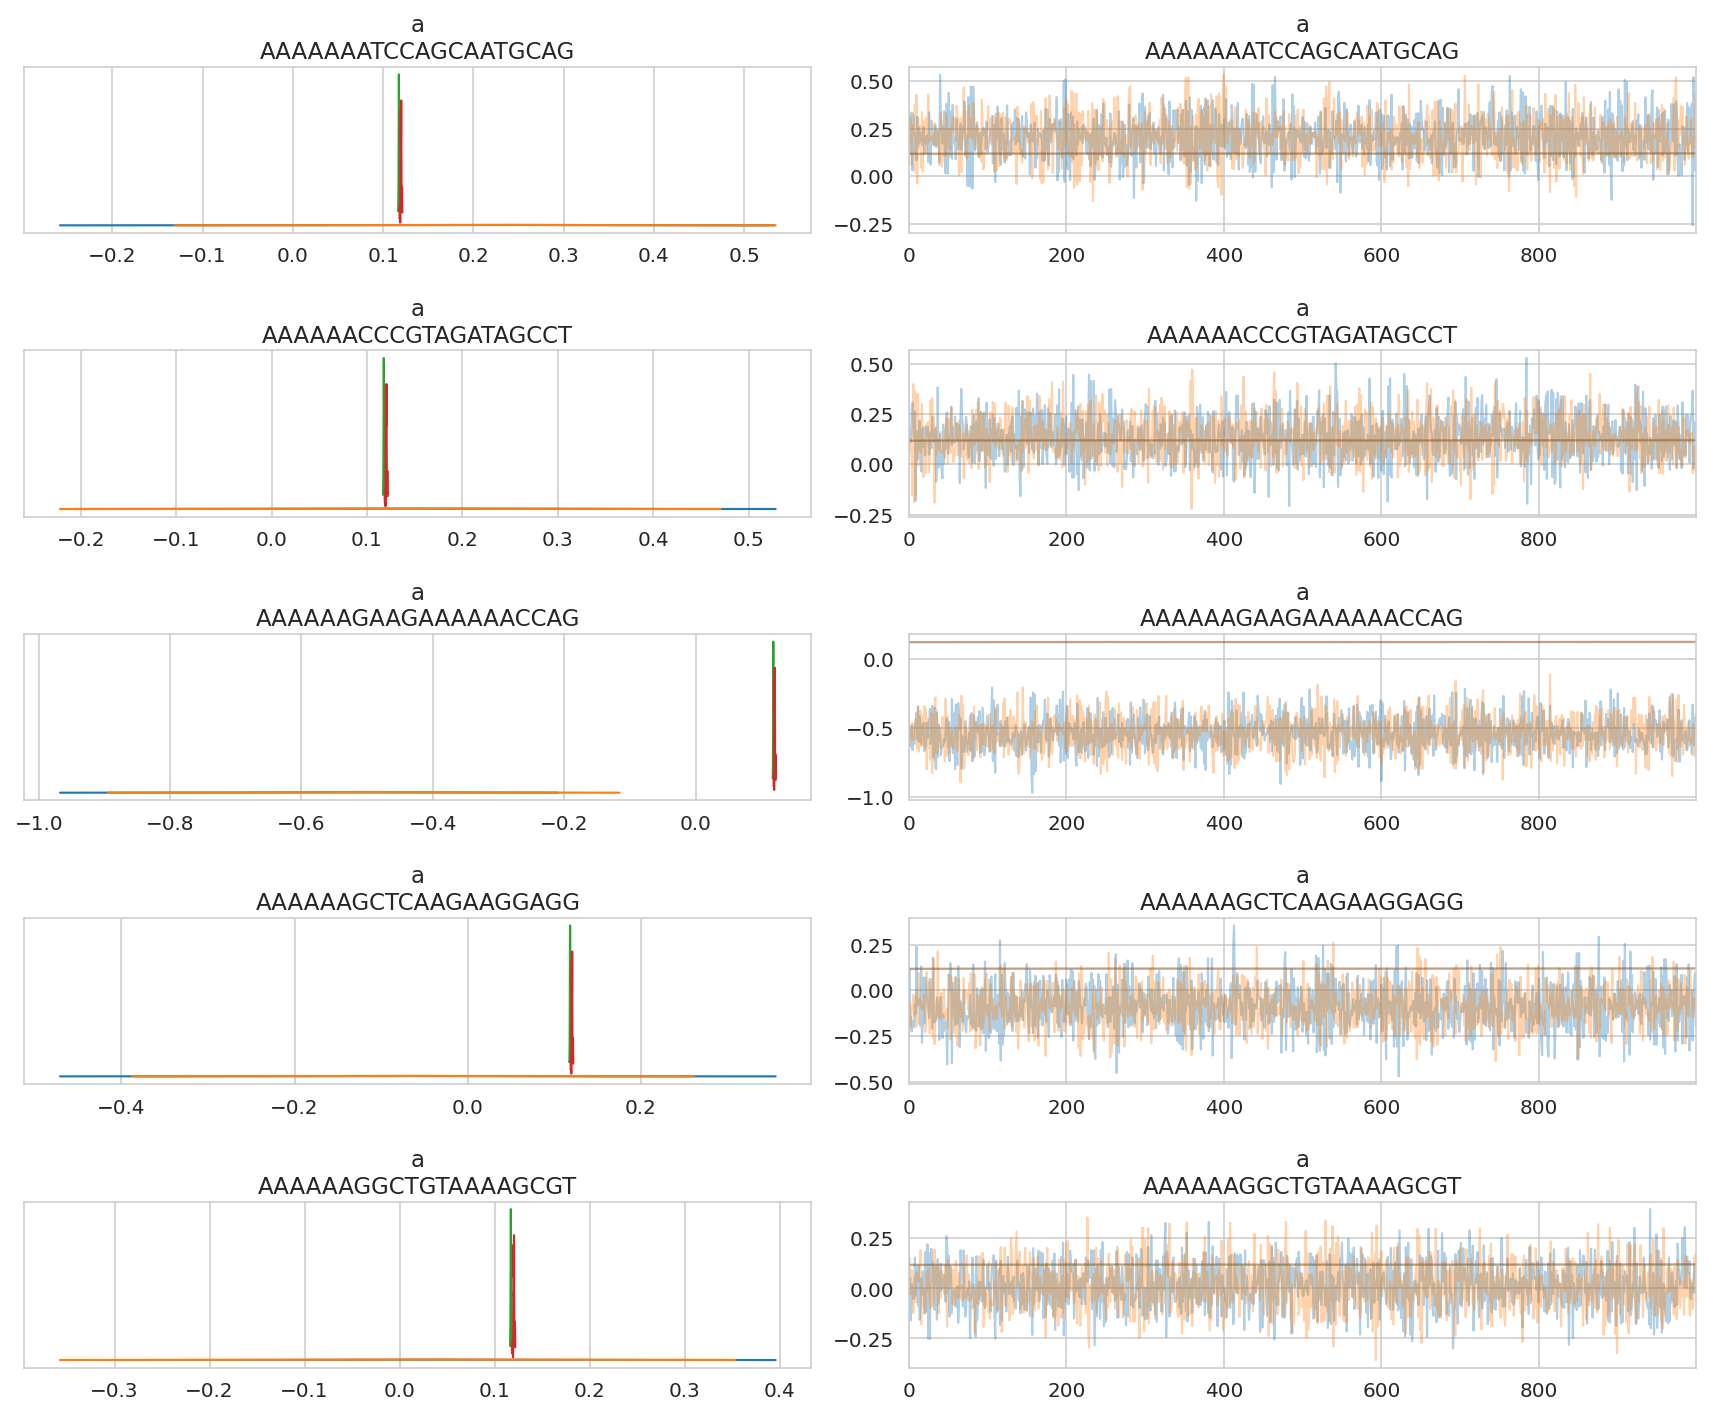

In [23]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

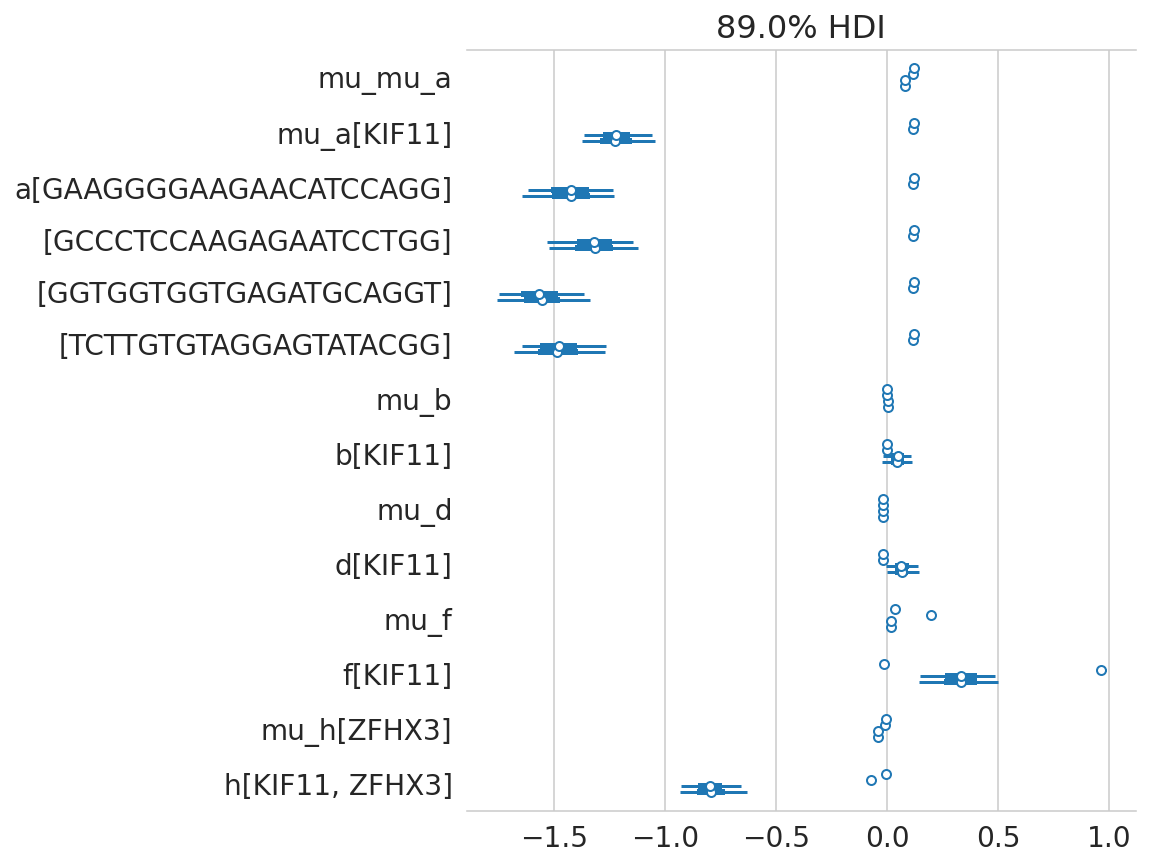

In [24]:
example_gene = "KIF11"
example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
    "sgrna"
].tolist()
az.plot_forest(
    trace,
    var_names=[
        "mu_mu_a",
        "mu_a",
        "a",
        "mu_b",
        "b",
        "mu_d",
        "d",
        "mu_f",
        "f",
        "mu_h",
        "h",
    ],
    coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
    combined=False,
    figsize=(6, 7),
)
plt.show()

In [25]:
prostate_post_summary.filter_string("var_name", "^sigma_*")

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name
5,sigma_a,0.106,0.106,0.000,0.212,0.053,0.040,5.0,16.0,2.23,sigma_a
7,sigma_mu_a,0.118,0.118,0.000,0.237,0.059,0.045,5.0,20.0,2.23,sigma_mu_a
8,sigma_b,0.029,0.029,0.000,0.058,0.014,0.011,5.0,32.0,2.10,sigma_b
9,sigma_d,0.025,0.025,0.000,0.051,0.013,0.010,6.0,51.0,1.75,sigma_d
10,sigma_f,0.303,0.325,0.086,0.865,0.162,0.124,5.0,11.0,2.74,sigma_f
11,sigma_h[0],0.099,0.066,0.007,0.163,0.033,0.025,5.0,11.0,2.74,sigma_h


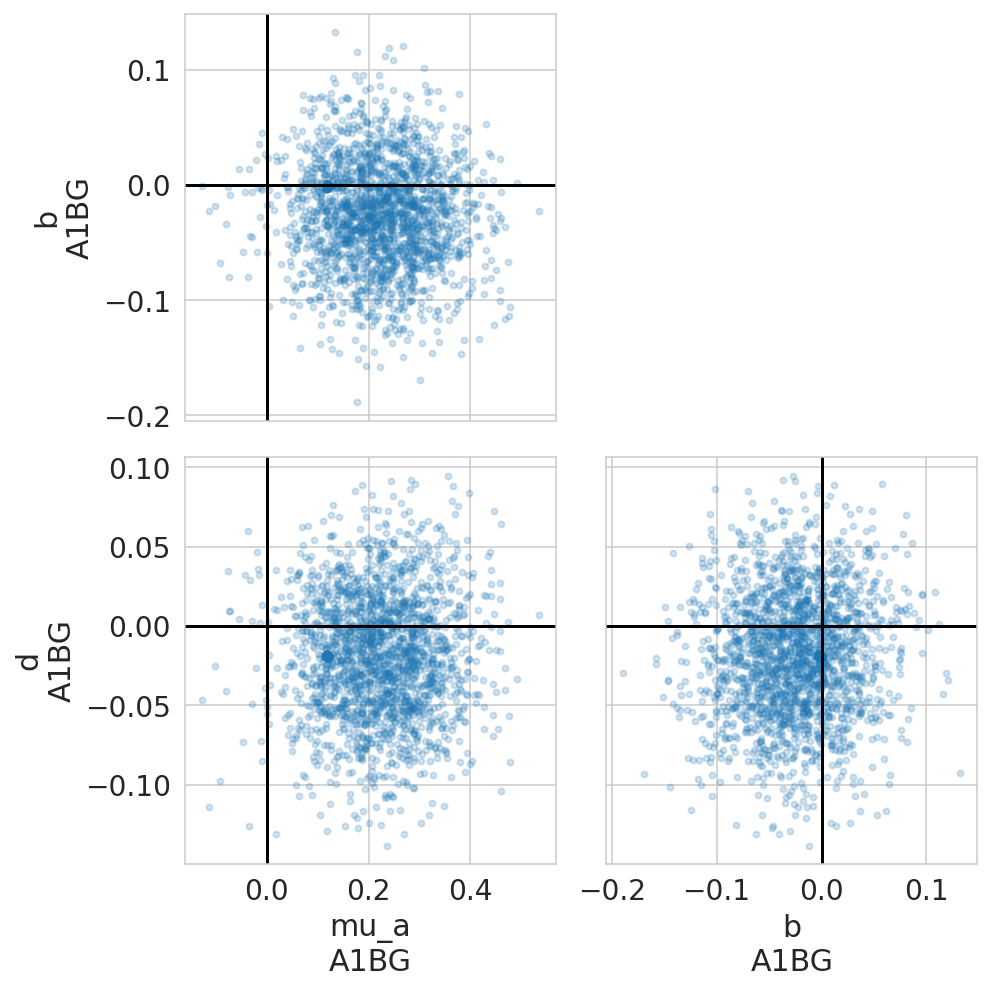

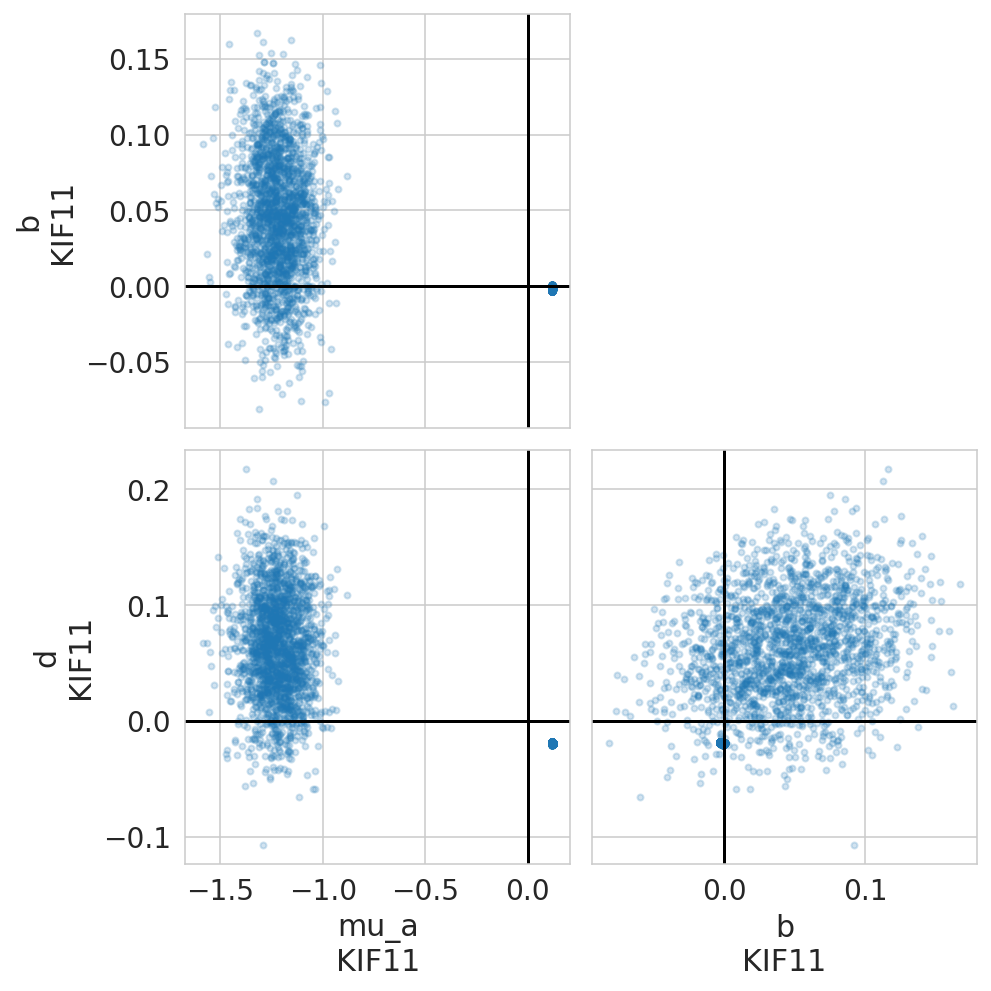

In [26]:
eg_gene = trace.posterior.coords["gene"].values[0]

for gene in [eg_gene, "KIF11"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

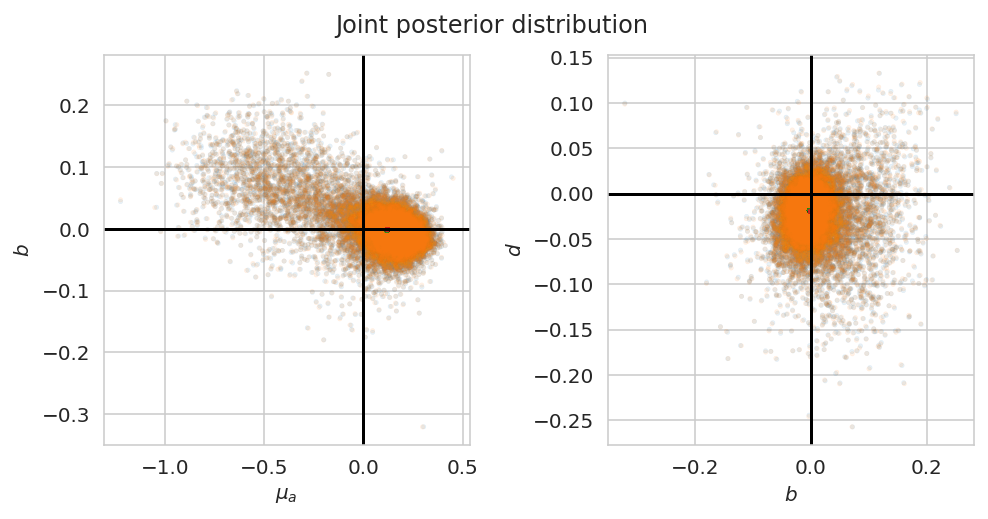

In [27]:
def _get_average_per_chain(trace: az.InferenceData, var_name: str) -> pd.DataFrame:
    return (
        trace.posterior[var_name]
        .mean(axis=(1))
        .to_dataframe()
        .reset_index()
        .astype({"chain": str})
    )


mu_a_post_avg = _get_average_per_chain(trace, "mu_a")
b_post_avg = _get_average_per_chain(trace, "b")
d_post_avg = _get_average_per_chain(trace, "d")

gene_post_avg = mu_a_post_avg.merge(b_post_avg, on=["chain", "gene"]).merge(
    d_post_avg, on=["chain", "gene"]
)


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(
    data=gene_post_avg,
    x="mu_a",
    y="b",
    hue="chain",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(
    data=gene_post_avg,
    x="b",
    y="d",
    hue="chain",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")
    ax.get_legend().remove()


fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

In [28]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)
gene_corr_post

,mean,sd,hdi_5.5%,hdi_94.5%,d1,d2,p1,p2
"genes_chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,0,0,mu_a,mu_a
"genes_chol_cov_corr[0, 1]",-0.194,0.325,-0.487,0.474,0,1,mu_a,b
"genes_chol_cov_corr[0, 2]",0.051,0.271,-0.506,0.457,0,2,mu_a,d
"genes_chol_cov_corr[0, 3]",-0.594,0.139,-0.812,-0.449,0,3,mu_a,f
"genes_chol_cov_corr[0, 4]",0.563,0.295,0.150,0.864,0,4,mu_a,h[ZFHX3]
"genes_chol_cov_corr[1, 0]",-0.194,0.325,-0.487,0.474,1,0,b,mu_a
"genes_chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,1,1,b,b
"genes_chol_cov_corr[1, 2]",-0.007,0.268,-0.535,0.437,1,2,b,d
"genes_chol_cov_corr[1, 3]",0.434,0.207,0.212,0.834,1,3,b,f
"genes_chol_cov_corr[1, 4]",-0.562,0.171,-0.935,-0.374,1,4,b,h[ZFHX3]


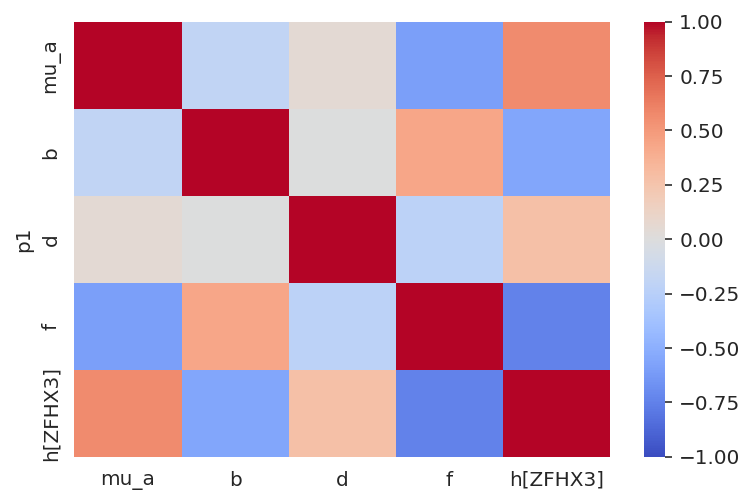

In [29]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [30]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 355308)

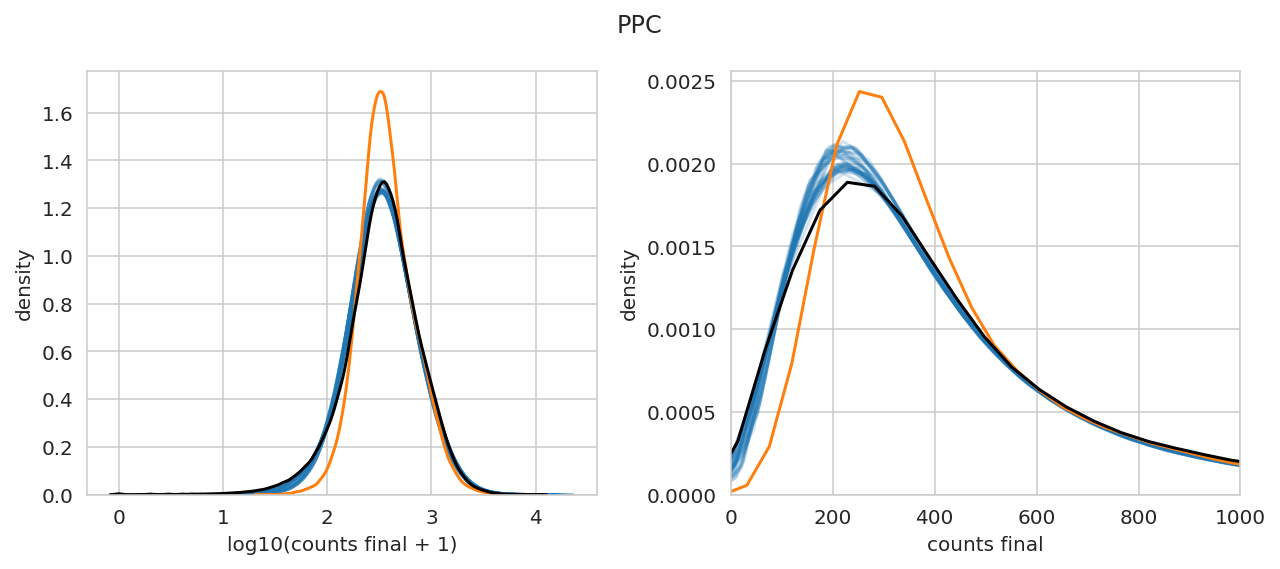

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")


for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg, color="tab:orange", ax=ax2)
sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [32]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 5.68 minutes


In [33]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-26

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-233.o2.rc.hms.harvard.edu

Git branch: simplify

pandas    : 1.4.3
qnorm     : 0.8.1
seaborn   : 0.11.2
matplotlib: 3.5.2
arviz     : 0.12.1
numpy     : 1.22.4

